In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emcee
import time
import corner
from matplotlib import rcParams
from astropy.modeling import models

## Creando los datos a ajustar

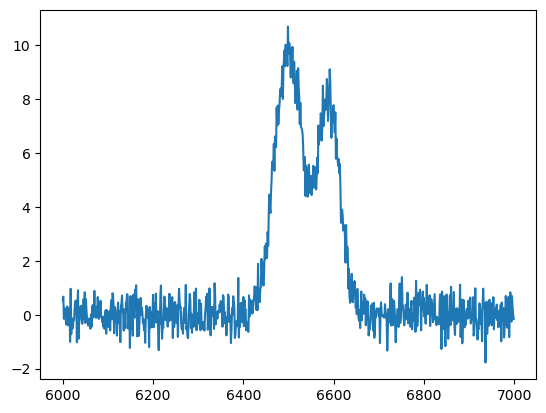

In [2]:
Wave = np.arange(6000,7000,1.25)
g1 = models.Gaussian1D(amplitude=10, mean=6500, stddev=30)
g2 = models.Gaussian1D(amplitude=8, mean=6590, stddev=25)

Espectro = g1(Wave)+g2(Wave)

ErrorRelativo = 0.5
Espectro = Espectro + np.random.normal(0,ErrorRelativo,len(Wave))
plt.plot(Wave,Espectro)
Espectro_Error = np.ones_like(Espectro)*ErrorRelativo

## Ahora algunas funciones 

In [3]:
def GaussianaDoble(Wave,A1,mean1,sigma1,A2,mean2,sigma2):
    g1 = models.Gaussian1D(amplitude=A1, mean=mean1, stddev=sigma1)
    g2 = models.Gaussian1D(amplitude=A2, mean=mean2, stddev=sigma1)
    return g1(Wave)+g2(Wave)

def lnprior(params):

    #Ranges used for the bounds
    Min_A1 = 0
    Max_A1 = 1e3
    
    if params[0]<Min_A1 or params[0]>Max_A1:
       	return -np.inf

    if params[1]<6000 or params[1]>7000:
       	return -np.inf

    if params[2]<0 or params[2]>1000:
       	return -np.inf    

    if params[3]<Min_A1 or params[3]>Max_A1:
       	return -np.inf

    if params[4]<6000 or params[4]>7000:
       	return -np.inf

    if params[5]<0 or params[5]>1000:
       	return -np.inf      
    return 0.0

def lnlike(params, Wave,Espectro,Espectro_Error):
    '''
    This function handles the log prob of the data compared with the models.   
    '''        
    y_model = GaussianaDoble(Wave,*params)

    #This is just the minus log of the probability. 
    return -0.5 * np.sum(np.log(2 * np.pi * Espectro_Error ** 2) + (Espectro - y_model) ** 2 / Espectro_Error ** 2)

def lnprob(params,  Wave,Espectro,Espectro_Error):
    '''
    This function handles the log prob  for the data and for the uninformed prior
    '''           
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    
    lnMeasured = lnlike(params, Wave,Espectro,Espectro_Error)
    if not np.isfinite(lnMeasured):
        return -np.inf
    
    return lp + lnMeasured

def prune(samples,lnprob, scaler=5.0, quiet=False):
    '''
    This function prunes the walkers (cleans them around the best fit)
    '''   
    
    minlnprob = lnprob.max()
    dlnprob = np.abs(lnprob - minlnprob)
    medlnprob = np.median(dlnprob)
    avglnprob = np.mean(dlnprob)
    skewlnprob = np.abs(avglnprob - medlnprob)
    rmslnprob = np.std(dlnprob)
    inliers = (dlnprob < scaler*rmslnprob)
    lnprob2 = lnprob[inliers]
    samples = samples[inliers]

    medlnprob_previous = 0.
    while skewlnprob > 0.1*medlnprob:
        minlnprob = lnprob2.max()
        dlnprob = np.abs(lnprob2 - minlnprob)
        rmslnprob = np.std(dlnprob)
        inliers = (dlnprob < scaler*rmslnprob)
        PDFdatatmp = lnprob2[inliers]
        if len(PDFdatatmp) == len(lnprob2):
            inliers = (dlnprob < scaler/2.*rmslnprob)
        lnprob2 = lnprob2[inliers]
        samples = samples[inliers]
        dlnprob = np.abs(lnprob2 - minlnprob)
        medlnprob = np.median(dlnprob)
        avglnprob = np.mean(dlnprob)
        skewlnprob = np.abs(avglnprob - medlnprob)
        if not quiet:
            print(medlnprob, avglnprob, skewlnprob)
        if medlnprob == medlnprob_previous:
            scaler /= 1.5
        medlnprob_previous = medlnprob
    samples = samples[lnprob2 <= minlnprob]
    lnprob2 = lnprob2[lnprob2 <= minlnprob]
    return samples,lnprob2

In [4]:
Nsteps = 1000
Nburn = int(Nsteps/2)
NWalkers = 100
Ndim = 6
Nthreads = 4
MCMCA = 1.5
starting_guesses = []

for i in range(NWalkers):
    aux = 	[
    		np.random.uniform(0,100),
    		np.random.uniform(6400,6450),
            np.random.uniform(0,50),
            np.random.uniform(0,100),
    		np.random.uniform(6600,6650),
            np.random.uniform(0,50),
    		]
    starting_guesses.append(np.array(aux))
starting_guesses = np.array(starting_guesses)   

print('Number of iterations:',Ndim*NWalkers*Nsteps)
sampler = emcee.EnsembleSampler(NWalkers, Ndim, lnprob, args=[Wave,Espectro,Espectro_Error],moves=emcee.moves.StretchMove(MCMCA))
currenttime = time.time()
Step = 1
for pos, prob, state in sampler.sample(starting_guesses, iterations=Nsteps):
    print('Step:',Step,'/',Nsteps)
    print("Mean acceptance fraction: %f"%(np.mean(sampler.acceptance_fraction)))
    print("Mean lnprob and Max lnprob values: %f %f"%(np.mean(prob), np.max(prob)))
    print("Time to run previous set of walkers (seconds): %f"%(time.time() - currenttime))
    currenttime = time.time()
    Step += 1

print('*** Done Fitting... ***')
ll = ['A1','Mean1','Sigma1','A2','Mean2','Sigma2']

emcee_trace = sampler.chain[:, :, :].reshape((-1, Ndim))
lnprobMeasured = sampler.lnprobability
print(50*'#')
print('*** Best fit ***')
for i in range(len(ll)):
   print(ll[i],':',emcee_trace[np.argmax(lnprobMeasured)][i])
print('best fit:',emcee_trace[np.argmax(lnprobMeasured)])
params = emcee_trace[np.argmax(lnprobMeasured)]

Number of iterations: 600000
Step: 1 / 1000
Mean acceptance fraction: 0.440000
Mean lnprob and Max lnprob values: -417823.375046 -13007.068867
Time to run previous set of walkers (seconds): 0.048457
Step: 2 / 1000
Mean acceptance fraction: 0.425000
Mean lnprob and Max lnprob values: -371431.268617 -13007.068867
Time to run previous set of walkers (seconds): 0.013867
Step: 3 / 1000
Mean acceptance fraction: 0.403333
Mean lnprob and Max lnprob values: -340167.302041 -12916.786417
Time to run previous set of walkers (seconds): 0.012108
Step: 4 / 1000
Mean acceptance fraction: 0.385000
Mean lnprob and Max lnprob values: -317452.151631 -12916.786417
Time to run previous set of walkers (seconds): 0.009411
Step: 5 / 1000
Mean acceptance fraction: 0.390000
Mean lnprob and Max lnprob values: -295986.542545 -12241.142466
Time to run previous set of walkers (seconds): 0.009455
Step: 6 / 1000
Mean acceptance fraction: 0.391667
Mean lnprob and Max lnprob values: -279283.870616 -12241.142466
Time to

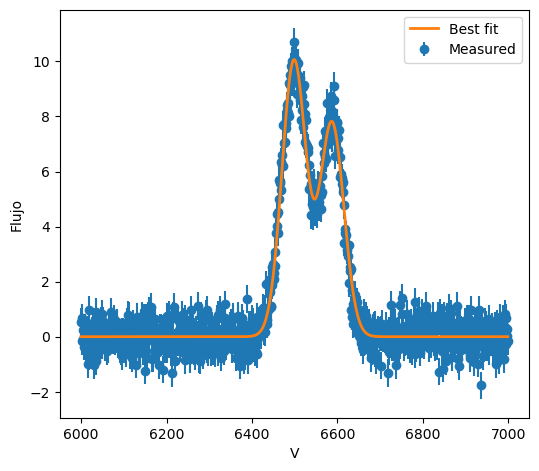

##################################################
*** Plotting Traces... ***


/var/folders/61/n5smjymx0mbc7xj9x9k6n3qc0000gn/T/ipykernel_78875/3812617006.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min(y),max(y))


##################################################
*** Acceptance Fraction ***
Mean acceptance fraction: 0.12353999999999997
As a rule of thumb, the acceptance fraction (af) should be 
                          between 0.2 and 0.5
          If af < 0.2 decrease the a parameter
          If af > 0.5 increase the a parameter
          
##################################################
*** Pruning... ***
1309.7110341867528 5442.904035137206 4133.193000950453
1309.7110341867528 5442.904035137206 4133.193000950453
5.346782010942206 619.8671229037428 614.5203408928006
5.322331305852515 611.3862464470648 606.0639151412122
2.169612770026106 4.95073563473293 2.7811228647068242
2.1644429575685535 2.7347997930689556 0.5703568355004021
2.161331454473043 2.497563330081962 0.3362318756089193
2.0606464562957854 2.247996801991533 0.1873503456957475
##################################################
*** Plotting Covariance... ***
##################################################
*** Posterior paramet

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

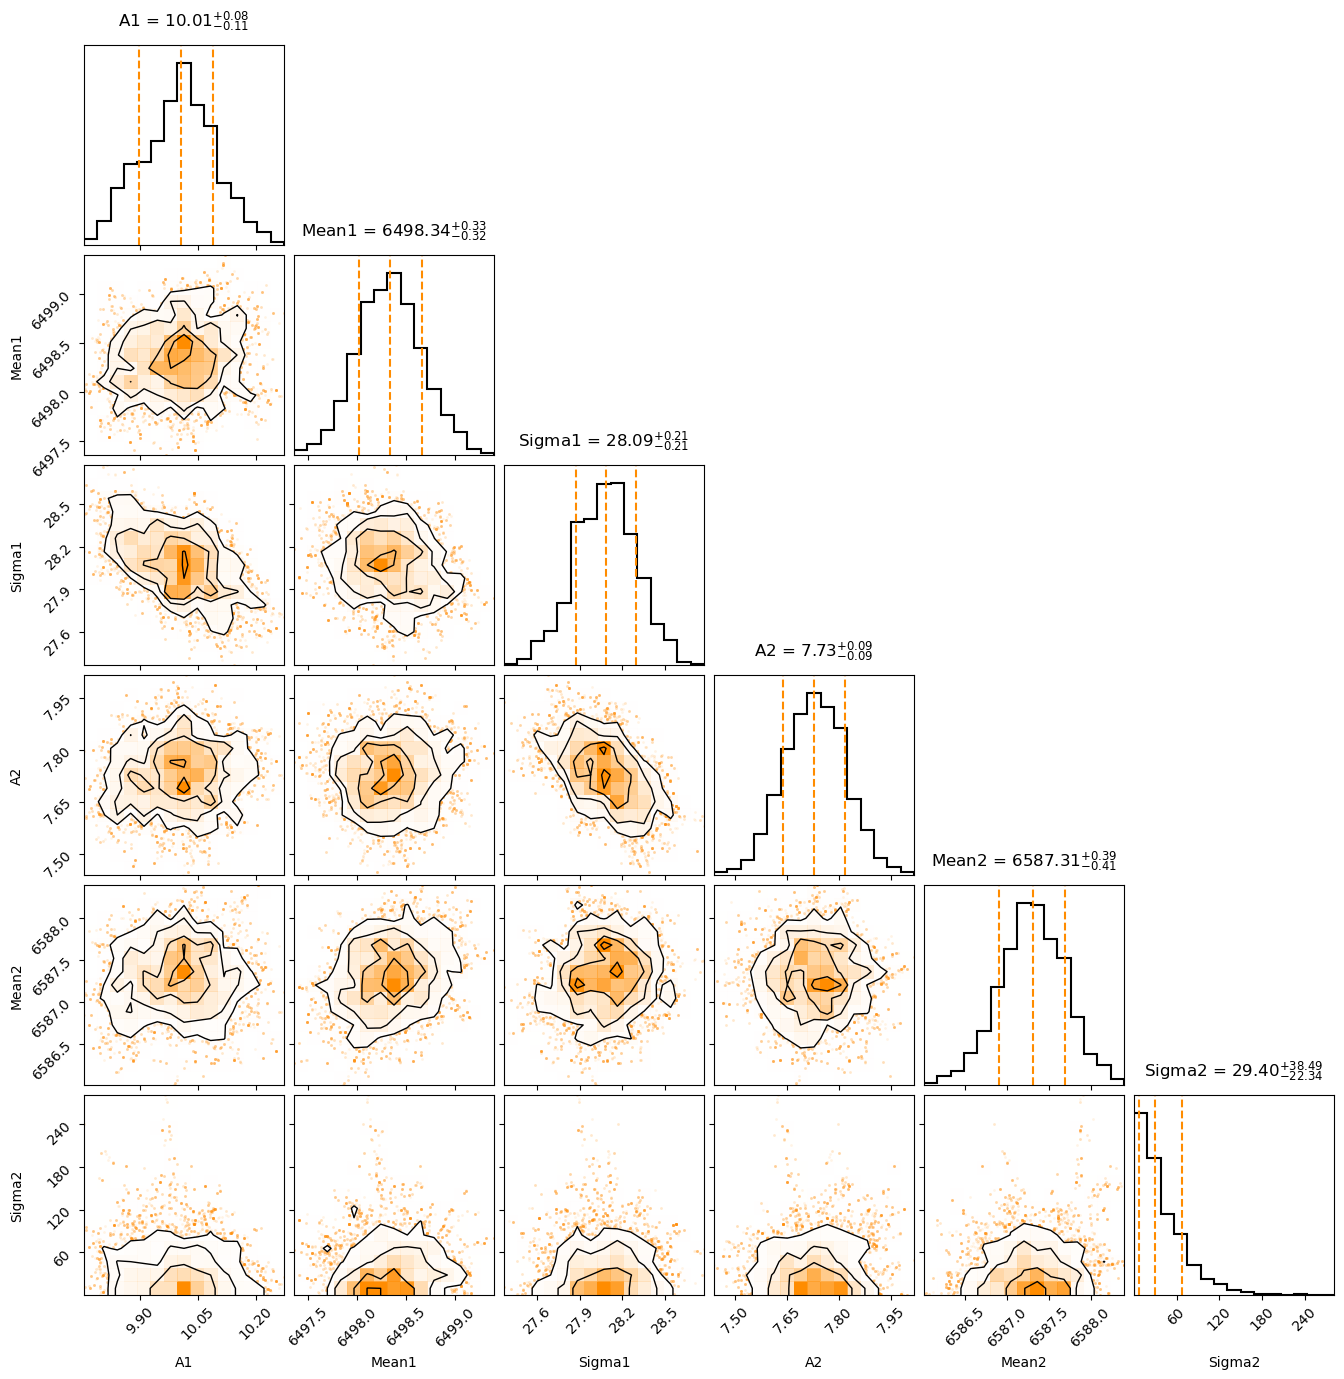

In [5]:
w, h = 1.0*plt.figaspect(0.9)
fig1 = plt.figure(figsize=(w,h))
fig1.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.95,wspace=0.00, hspace=0.05)
ax = fig1.gca()

plt.errorbar(Wave,Espectro,yerr=Espectro_Error,marker='o',ls='',label='Measured',zorder=0)


Lineas_Fiteada =  GaussianaDoble(Wave,*params)
plt.plot(Wave, Lineas_Fiteada,ls='-',lw=2, label="Best fit",zorder=1)


plt.legend(loc=0)
plt.xlabel(r'V')
plt.ylabel(r'Flujo')
plt.savefig('MCMC_BestFit.pdf')
plt.show()
plt.clf()

print(50*'#')
print('*** Plotting Traces... ***')
x = np.array([])
y = np.array([])
maxlnprob = np.max(lnprobMeasured)
for i in range(len(lnprobMeasured)):
    x = np.append(x,range(len(lnprobMeasured[i])))
    y = np.append(y,maxlnprob - lnprobMeasured[i])
plt.figure()
plt.hexbin(x[y>0],y[y>0], gridsize=[70,30], cmap='inferno',bins='log',mincnt=1,yscale='log',linewidths=0)
plt.ylabel('maxlnprob -lnprob')
plt.xlabel('iteration')
try:
    plt.xlim(min(x),max(x))
    plt.ylim(min(y),max(y))
except:
    print('Negative values in Convergence....')
plt.savefig('Convergence.png',dpi=300)
plt.close()

for ID in range(Ndim):
    plt.figure()
    x = np.array([])
    y = np.array([])
    for i in sampler.chain:
        x = np.append(x,range(len(i.T[ID])))
        y = np.append(y,i.T[ID])

    plt.figure()
    if (max(y)/min(y))>50 and len(y[y<0])<1:
        plt.hexbin(x,y, gridsize=[70,30], cmap='inferno',bins='log',mincnt=1,yscale='log',linewidths=0)
    else:
        plt.hexbin(x,y, gridsize=[70,30], cmap='inferno',bins='log',mincnt=1,linewidths=0)
    plt.ylabel(ll[ID])
    plt.xlabel('iteration')
    plt.xlim(min(x),max(x))
    plt.ylim(min(y),max(y))
    plt.savefig(ll[ID]+'_trace.png',dpi=300)
    plt.close()

print(50*'#')
print('*** Acceptance Fraction ***')
af = sampler.acceptance_fraction
af_msg = '''As a rule of thumb, the acceptance fraction (af) should be 
                          between 0.2 and 0.5
          If af < 0.2 decrease the a parameter
          If af > 0.5 increase the a parameter
          '''
print("Mean acceptance fraction:", np.mean(af))
if np.mean(af)<0.2 or np.mean(af)>0.5:
    print(af_msg)


samples = sampler.chain[:, Nburn:, :].reshape((-1, Ndim))
lnprob_aux = sampler.lnprobability[:, Nburn:].reshape(-1)
print(50*'#')
print('*** Pruning... ***')
try:
    samples,lnprob2 = prune(samples,lnprob_aux)
except:
    print('Prunning failed....')

rcParams.update({'figure.autolayout': False})
print(50*'#')
print('*** Plotting Covariance... ***')
fig = corner.corner(samples, labels=ll,title_kwargs={'y':1.05},title_fmt=".2f",use_math_text=True,bins=15,quantiles=[0.16, 0.5, 0.84],show_titles=True,color='DarkOrange',hist_kwargs={'color':'black','linewidth':1.5},contour_kwargs={'linewidths':1,'colors':'black'})
fig.savefig("Covariance.pdf")
print(50*'#')
print('*** Posterior parameters and percentiles [16,50,84]***')
for ID in range(Ndim):
  pc = np.percentile(samples.T[ID], [16,50,84])
  print(ll[ID]+':',round(pc[1],4),'+/-',round(np.mean([pc[2]-pc[1],pc[1]-pc[0]]),4),pc)


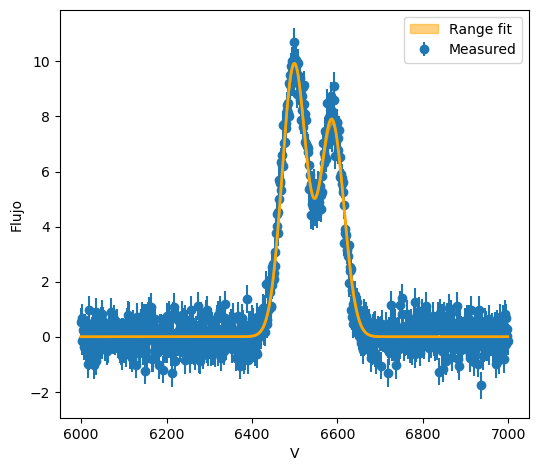

<Figure size 640x480 with 0 Axes>

In [6]:

##Plot range of best fits


w, h = 1.0*plt.figaspect(0.9)
fig1 = plt.figure(figsize=(w,h))
fig1.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.95,wspace=0.00, hspace=0.05)
ax = fig1.gca()
plt.errorbar(Wave,Espectro,yerr=Espectro_Error,marker='o',ls='',label='Measured',zorder=0)


# Lineas_Fiteada =  GaussianaDoble(Wave,*params)
# plt.plot(Wave, Lineas_Fiteada,ls='-',lw=2, label="Best fit",zorder=1)

Models = []
for i in range(200):
    Models.append(GaussianaDoble(Wave,samples[i][0],samples[i][1],samples[i][2],samples[i][3],samples[i][4],samples[i][5]))

Models = np.array(Models)

Models = np.transpose(Models)

Median_Model = []
Model_e1 = []
Model_e2 = []

for i in range(len(Models)):
    aux = np.percentile(Models[i],[16,50,84])
    Median_Model.append(aux[1])
    Model_e1.append(aux[0])
    Model_e2.append(aux[2])

plt.plot(Wave, Median_Model,ls='-',lw=2,color='orange')
plt.fill_between(Wave,Model_e1,Model_e2,color='orange',alpha=0.5,label="Range fit")


plt.legend(loc=0)
plt.xlabel(r'V')
plt.ylabel(r'Flujo')
plt.savefig('MCMC_Range.pdf')
plt.show()
plt.clf()